In [14]:

import re # Regex
import string # String manipulation
import spacy # NLP tooling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Deep learning
import matplotlib.pyplot as plt # Visualization
from sklearn.model_selection import train_test_split # Split train and validation set
from sklearn.preprocessing import LabelEncoder # Encode label into numerical format


In [15]:
data =pd.read_csv('/content/drive/MyDrive/apriori/Total_News_Data.csv')

In [16]:
data.head(5)

,Unnamed: 0,news_headline,news_article,news_category
0,1,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,2,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,3,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,4,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,5,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology


In [17]:
def clean_text(text):
    regex_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_digits = str.maketrans('', '', string.digits + string.punctuation)
    text = re.sub(regex_html, '', text)
    text = text.translate(remove_digits)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

X= (data.news_headline + " " + data.news_article).apply(clean_text)


In [18]:
le = LabelEncoder().fit(data['news_category'])
data['label'] = le.transform(data['news_category'])
X_train,X_test,y_train,y_test=train_test_split(X,data['label'],test_size=0.2, random_state=42)

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8192, oov_token='-')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

x_train = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=128,
    padding='post',
    truncating='post'
)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=128,
    padding='post',
    truncating='post'
)

In [25]:
x_train.shape

(9696, 128)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((128,)),
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index), output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(y_train)), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 128, 64)           1555648   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 256)         197632    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                

In [27]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
    ), tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=2
    )]
)

Epoch 1/10
303/303 [==============================] - 38s 90ms/step - loss: 1.1755 - accuracy: 0.5249 - val_loss: 0.3813 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 2/10
303/303 [==============================] - 8s 26ms/step - loss: 0.2729 - accuracy: 0.9179 - val_loss: 0.2293 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 3/10
303/303 [==============================] - 9s 29ms/step - loss: 0.1622 - accuracy: 0.9505 - val_loss: 0.2406 - val_accuracy: 0.9295 - lr: 0.0010
Epoch 4/10
303/303 [==============================] - 7s 23ms/step - loss: 0.1244 - accuracy: 0.9620 - val_loss: 0.2247 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 5/10
303/303 [==============================] - 6s 20ms/step - loss: 0.1183 - accuracy: 0.9603 - val_loss: 0.1949 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 6/10
303/303 [==============================] - 5s 15ms/step - loss: 0.1079 - accuracy: 0.9613 - val_loss: 0.1866 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 7/10
303/303 [==============================] - 5s 17ms/s

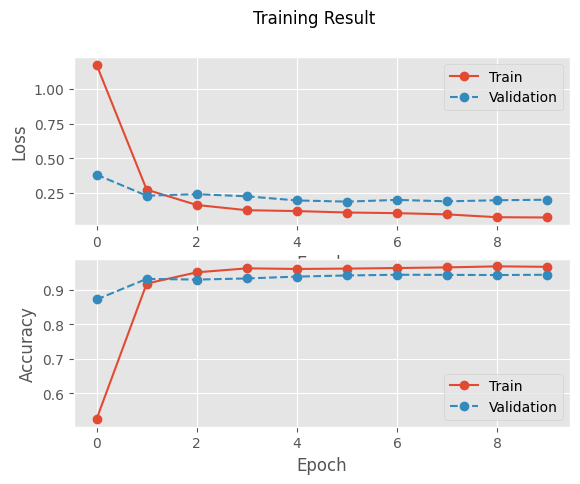

In [28]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Training Result')
ax1.plot(history.history['loss'], 'o-', label='Train')
ax1.plot(history.history['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], 'o-', label='Train')
ax2.plot(history.history['val_accuracy'], 'o--', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()